# Langevin dynamics simulation of the vibrational motion of HF

As described in the companion document to this notebook, this exercise involves using the BBK integrator to perform a Langevin dynamics simulation of the HF molecule

We will start by importing a few useful libraries - these are packages of python code that provide capabilities to do numerical calculations, plot data, etc. We will then create arrays (or lists) for the bond length and energies at each bond length as in last week's computational exercise. 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

molecules = []
r_array = [0.5, 0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3] 
E_array = [-99.65145319155353, -99.8994262443721,-100.06621001317194,-100.17756325854646,-100.25063259195414,-100.2970313588523,-100.32474168482375,-100.33931605978479,-100.34465565789081,-100.34352787324143,-100.33791544225228,-100.31857920174716,-100.29403975969775,-100.26820624042988,-100.24311492569184,-100.21980547092805,-100.19879112534593,-100.18029259214076,-100.16434868570335,-100.15087255990257,-100.13968771534014,-100.13055798203477,-100.12321514624568,-100.11738316835266]

#plt.plot(r_array, E_array, 'red')
#plt.show()

We now fit our energy potential surface using a *spline* just like in the previous computational exercise. We will then differentiate this spline to obtain a force (and differentiate the force to obtain our spring constant). While we are setting things up, let us also calculate the equilibrium both length for HF and the reduced mass of HF in atomic units (just like last time). We'll also need to perform the same interpolation as last time.

In [4]:
''' Create array of bond lengths in atomic units called r_array_au and fit PES to splines in this cell! '''
r_array_au = np.array(r_array) * 1.89
''' create a cubic spline for the energies vs bond length in atomic units here! '''
E_spline = InterpolatedUnivariateSpline(r_array_au, E_array, k=3)

### form a much finer grid to evaluate spline object at
r_fine = np.linspace(0.5*1.89,2.3*1.89,200)
### compute the interpolated/extrapolated values for Energy on this grid
E_fine = E_spline(r_fine)
minE = min(E_fine)

#plt.plot(r_fine, E_fine, 'blue')
#plt.show()

fE = E_spline.derivative()
cE = fE.derivative()

### Find Equilibrium Bond-Lengths for each level of theory
Req_idx = np.argmin(E_fine)

### find the value of the separation corresponding to that index
r_eq = r_fine[Req_idx]

### print equilibrium bond-lengths at each level of theory!
print("Equilibrium bond length is ",r_eq, "atomic units")
print("Req is ",r_eq/1.89, "Angstroms")

### mass of hydrogen in atomic units
mH = 1836.
### mass of fluorine in atomic units
mF = 34883.

''' compute reduced mass and store it to variable mu here! '''
mu = 13625.#mH * mF/(mH + mF)
### Print the reduced mass!
print("Reduced mass is ",mu, "atomic units")

### evaluate the second derivative at r_eq to get k
k = cE(r_eq)
### print the spring constant
print("The spring constant for the HF molecule viewed as a harmonic oscillator is ", k, "atomic units")

Equilibrium bond length is  1.7313919597989949 atomic units
Req is  0.9160804020100503 Angstroms
Reduced mass is  13625.0 atomic units
The spring constant for the HF molecule viewed as a harmonic oscillator is  0.6400845065940467 atomic units


For our simulation of HF motion as a function of time, we need to define an initial state for our molecule. Since our molecule is being constantly perturbed by external forces (e.g. solvent molecules), it need not be in its lowest energy state, but rather it is in some "random" relatively low energy state.

In [5]:
### define "ground-state" velocity:
v = np.sqrt( np.sqrt(k/mu)/(2*mu))

### get random position and velocity for HF within a reasonable range:
### to think about: are these ranges reasonable given the temperature at which we want to simulate our system?
###                 how would you evaluate the reasonability of these initial conditions?
r_init = np.random.uniform(0.5*r_eq,1.5*r_eq)
v_init = np.random.uniform(-v,v)

### print initial position and velocity
print("Initial separation is",r_init, "atomic units")
print("Initial velocity is",v_init, "atomic units")
### establish time-step for integration to be 0.02 atomic units... this is about 0.01 femtoseconds
### you may want to see what happens (e.g. to mean "instantaneous temperature" when you change this number)
dt = 0.02

### get force on particle 
F_init = -1*fE(r_init)

Initial separation is 1.0773063275814074 atomic units
Initial velocity is 0.000158677645884242 atomic units


Now we need to set up some parameters for our Langevin dynamics run. Changing our initial state (re-running the code above) will change the resulting Langevin dynamics trajectory as will changing the parameters below (re-running the code below)

In [9]:
### parameters for Langevin Equation: temperature and drag
### note that in atomic units, the Boltzmann constant is unity
temperature = 0.00094 # approximately room temperature (295 K) in atomic units
gamma = 0.02; # this gamma may be a bit high ... you may want to see what happens when you decrease this number

### use parameters set above to get initial perturbation of force for Langevin dynamics
rp_init = np.sqrt(2*temperature*gamma*mu/dt)*np.random.normal(0,1)

Next we need to define our BBK function and call it to update our position and velocity. Note that in each BBK update of our velocity we need to know our current random perturbation of the force as well as the random perturbation of force at the next time step. One way to keep track of the perturbations is to output the perturbation for the next time step to use as the current perturbation in the next BBK function call: thus we need to have the current perturbation be input to the BBK function call. We also need to input the drag coefficient, gamma, and the temperature ... since the Boltzmann constant is unity in atomic units, we do not need to worry about it) into the BBK function. The following partially-complete function will update the position. You should complete the function to also update the velocity (note: Remove lines that update velocity and have students implement them).

In [10]:
def BBK(r_curr, v_curr, rp_curr, gamma_val, temperature_val, mu, f_interp, dt):
    
    ### get acceleration at current time: (force + current perturbation on force)/mass - drag
    a_curr = (-1*f_interp(r_curr) + rp_curr)/mu - gamma_val*v_curr
    ### THE ABOVE IS EQUATION 6 IN THE ASSIGNMENT PROF. DAS POSTED
    #v_curr = a_curr * dt
    ### update velocity for half time step, for such a small time step can approximate dv = adt
    ### THINK ABOUT IT: DO YOU REALLY HAVE TO DO THIS STEP?
    
   
    ### use current acceleration and velocity to update position
    ### WRITE CODE IMPLEMENTING THE FORMULA YOU OBTAINED, AS PART OF EXERCISE 1, FOR r(t+dt) HERE
    r_fut = r_curr + v_curr * dt + 0.5 * a_curr * dt**2
    
    ### calculate the rp_future
    rp_fut = np.sqrt(2*temperature_val*gamma_val*mu/dt)*np.random.normal(0,1)
    
    ### use rp_fut to get future acceleration a_fut (a_tilde at the future time in the assignment), 
    ### note that we cannot take future drag into account as we have not calculated our future velocity yet
    ### CODE IMPLEMENTING EQUATION 7 IN THE ASSIGNMENT DAS POSTED GOES HERE
    a_fut = (-1*f_interp(r_fut) + rp_fut)/mu
    
    ### use current and future acceleration to get future velocity v_fut
    ### note that we have to "correct" our formula relative to the formula for velocity Verlet
    ### as we have not included our future drag in our future acceleration
    
    v_fut = (v_curr + 0.5 * a_curr * dt + 0.5 * a_fut *dt) / (1 + 0.5 * gamma_val * dt)
    # v_fut = (v_halftime + 0.5*a_fut*dt)/(1+0.5*gamma_val*dt)
    ### WRITE CODE IMPLEMENTING THE FORMULA YOU OBTAINED, AS PART OF EXERCISE 1, FOR r(t+dt) HERE
    
    result = [r_fut, v_fut, rp_fut]
    
    return result


Now that we have implemented the BBK algorithm as a python function, let's actually try using it to simulate HF bond vibrations.

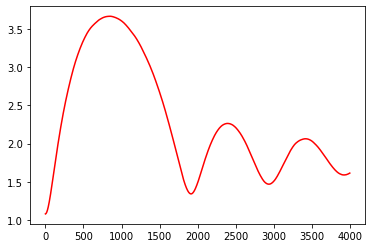

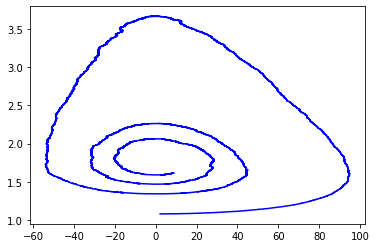

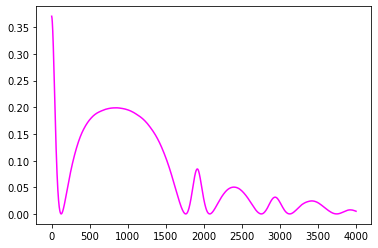

Mean Energy for next to last 100000 time steps of the trajectory is  0.003082321998983653  Hartrees
Mean Energy for last 100000 time steps of the trajectory is  0.005938339681173765  Hartrees


In [8]:
### how many updates do you want to perform?
N_updates = 200000

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
e_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init
e_vs_t[0] = (E_spline(r_init)-minE)+0.5*mu*v_init**2

### first BBK update
result_array = BBK(r_init, v_init, rp_init, gamma, temperature, mu, fE, dt)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = BBK(result_array[0], result_array[1], result_array[2], gamma, temperature, mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    e_vs_t[i] = (E_spline(result_array[0])-minE)+0.5*mu*v_init**2

### Plot the trajectory of bondlength vs time:
plt.plot(t_array, r_vs_t, 'red')
plt.show()

### plot the phase space trajectory of position vs momentum
plt.plot(mu*v_vs_t, r_vs_t, 'blue')
plt.show()

### plot the total energy vs. time: does the average energy seem to converge?
plt.plot(t_array,e_vs_t,'magenta')
plt.show()

### mean energy for next to last and last ten thousand time steps: does each equal k_B*T? are they similar to each other?
print("Mean Energy for next to last 100000 time steps of the trajectory is ",np.mean(e_vs_t[(N_updates-20000):(N_updates-10000)])," Hartrees")
print("Mean Energy for last 100000 time steps of the trajectory is ",np.mean(e_vs_t[(N_updates-10000):N_updates])," Hartrees")